In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
from scipy.spatial.distance import mahalanobis
import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.unknown_truncation_normal import truncated_normal
from delphi.utils.datasets import TruncatedNormalDataset
from delphi.utils.constants import COSINE
from delphi.oracle import Left, Interval, Unknown_Gaussian
import datetime

# Helpers

In [2]:
STORE_PATH = '/home/pstefanou/truncated'
STORE_TABLE_NAME = 'truncated_df'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_kl': float,
    'naive_kl': float,
    'alpha': float, 
    'C': float,
})

Logging in: /home/pstefanou/truncated/3aba34e5-edd7-47d9-8163-a989a8962cde


## Default Experiment Parameters

In [3]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 1

# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'degree': 100, 
    'custom_lr_multiplier': COSINE,
})

In [4]:
# perform each experiment a total of 10 times
for iter_ in range(10): 
    for C in [.5, -1, -.5, 0, .5]:
        # truncation oracle
        PREDICATE = Left(Tensor([C]))
        # sample from a univariate gaussian distribution
        M =MultivariateNormal(ch.zeros(DIMS), ch.eye(DIMS))
        samples = M.sample(ch.Size([NUM_SAMPLES]))
        S = samples[PREDICATE(samples).nonzero(as_tuple=False).flatten()]
        args.__setattr__('alpha', Tensor([S.size(0) / NUM_SAMPLES]))
        args.__setattr__('phi', Unknown_Gaussian(S.mean(0), S.var(0).unsqueeze(0), S, args.degree))

        # truncated normal distribution
        data = TruncatedNormalDataset(S)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        truncated = truncated_normal(phi=args.phi, alpha=args.alpha, bias=args.bias, epochs=args.epochs, 
                                                      lr=args.lr, tol=args.tol, custom_lr_multiplier=args.custom_lr_multiplier)
        results = truncated.fit(S)

        # metrics
        delphi_kl = ch.distributions.kl.kl_divergence(M, results)
        naive_kl = ch.distributions.kl.kl_divergence(M, MultivariateNormal(S.dataset.loc, S.dataset.var.unsqueeze(0)))

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_kl': delphi_kl,
            'naive_kl': naive_kl,
            'alpha': float(args.alpha),
            'C': C,
        })

# close current store
store.close()


avg score: 
 [-0.0033, -0.0023]


# Results

In [5]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 12/12 [00:00<00:00, 381.78it/s]

,delphi_kl,naive_kl,alpha,C,exp_id
0,1.574871,3.064851,0.3100,0.5,c84fadee-2923-4135-8a9d-561f392f7702
1,0.069799,0.126323,0.8420,-1.0,c84fadee-2923-4135-8a9d-561f392f7702
2,0.246365,0.456318,0.6817,-0.5,c84fadee-2923-4135-8a9d-561f392f7702
0,1.826601,3.171499,0.3081,0.5,3aba34e5-edd7-47d9-8163-a989a8962cde
1,0.096751,0.138289,0.8409,-1.0,3aba34e5-edd7-47d9-8163-a989a8962cde


# All Trials

all trials:


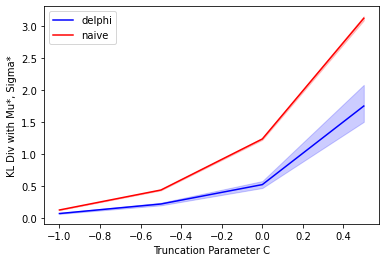

In [6]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_kl', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='naive_kl', label='naive', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='KL Div with Mu*, Sigma*')
plt.show()

(array([156., 152., 125., 126., 135., 126., 112., 123., 123., 110., 111.,
        105.,  91., 107.,  96., 102.,  72.,  89.,  81.,  79.,  59.,  53.,
         42.,  49.,  60.,  47.,  31.,  52.,  41.,  36.,  49.,  37.,  34.,
         28.,  35.,  22.,  21.,  13.,  20.,   9.,  23.,  21.,  16.,  21.,
          9.,  16.,   9.,   4.,  10.,   8.,   9.,   8.,   7.,   7.,   2.,
          3.,   4.,   1.,   1.,   3.,   1.,   1.,   1.,   0.,   1.,   0.,
          1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([0.50008863, 0.5411928 , 0.582297  , 0.6234012 , 0.6645054 ,
        0.7056096 , 0.7467138 , 0.787818  , 0.8289222 , 0.8700264 ,
        0.9111306 , 0.9522348 , 0.993339  , 1.0344433 , 1.0755475 ,
        1.1166517 , 1.1577559 , 1.19886   , 1.2399642 , 1.2810684 ,
        1.3221726 , 1.3632768 , 1.404381  , 1.4454852 , 1.4865894 ,
        1.5276936 , 1.5687978 , 1.609902  , 1.6510062 , 1.6921104 ,
        1.7332146 , 1.7743188 , 1.815423  , 1.8565272 , 1.8976314 ,
        1.938735

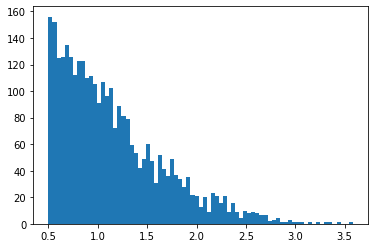

In [29]:
plt.hist(samples[PREDICATE(samples).nonzero(as_tuple=False).flatten()].T, bins=75)

TypeError: float() argument must be a string or a number, not '_LocIndexer'

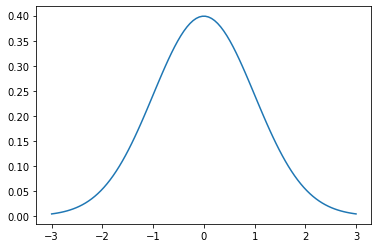

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="actual")

pred_mu = float(results.loc)
pred_cov = float(results.covariance_matrix)
plt.plot(x, stats.norm.pdf(x, pred_mu, pred_cov), label="pred")

emp_mu = float(S.dataset.loc)
emp_cov = float(S.dataset.var)
plt.plot(x, stats.norm.pdf(x, emp_mu, emp_cov), label="emp")


plt.legend()

plt.show()

In [6]:
print(args.custom_lr_multiplier)

None
